# K-Means Clustering
-----

NOTE: Please read this notebook [here](https://nbviewer.jupyter.org/github/FG-33/ml-algorithms/blob/master/clustering/k-means.ipynb?flush_cache=True). It is not rendered properly on Github.

This notebook was created using the concepts and ideas conveyed in Stanford's lecture/course *Machine Learning* by Andrew Ng.

## Theory

K-Means clustering is an algorithm with the goal to cluster/group data into $K$ groups/clusters based on their similarity. 

insert orher/Nachher Vergleich


The similarity will be measured with a fixed heuristic. An example for data points in a two dimensional space could, for example, be the euclidian distance. Therefore the initial situation when using k-means consists of a set of x-dimensional data points:

$$ X = \{x^{(1)}, x^{(2)}, x^{(3)}, x^{(4}, .., x^{(m)}\} $$

and a heuristic (the *euclidian distance* between a data point $x$ and a cluster center $\mu$, also known as centroid):

$$ d = || x - \mu ||^2 $$ 

In the beginning of the algorithm $K$ cluster centers are initialized. Every data point is then assigned to the centroid it's closest to. This assignement of a data point to a cluster is noted as $c^{(i)}$:

$$ c^{(i)} = min_k || x^{(i)} - \mu_k ||_2 $$

After assigning the $m$ data points the centroid's shifted based on it's assigned data points. The mean position of the data points is calculated and then assigned as the new position for their centroid. Next, the data points are assigned to their closest centroid again and the centroid's position is adjusted. This is repeated until the distribution does not change anymore. In the end the a cost can be calculated to measure how good the resuling clustering is:

$$J(c^{(1)}, .., c^{(m)}, \mu_1, .., \mu_K) = \frac{1}{m} \sum_{i=1}^m || x^{(i)} - \mu_{c^{(i)}} ||_2 $$ 

In practive multiple configurations with random initialized clusters are processed until convergence to compare the final cost to get a good fit.

----

## Implementation

In [1]:
import numpy as np

def euclidean(a, b):
    """ Calculates the euclidean distance between two vectors.
    
    :param a: first vector
    :param b: second vector
    
    :return distance: euclidean distance between a and b
    """
    return np.sqrt(np.power(a - b, 2).sum())
    
def k_means(x, k, scale=1.5, epsilon=0.005):
    """ Clusters the given data using the k-means algorithm.
    
    :param x: n x m matrix containing m n-dimensional vectors representing data points
    :param k: number of centroids
    :param scale: scale value to increase area where centroids can be generated
                  (1 = only in the area where data points are)
    :param epsilon: break condition
    
    :return c_list: indexes of centroids the corresponding data point is assigned to for each iteration
    :return centroids: n x k matrix containing k n-dimensional vectors representing centroid positions
                       for each iteration
    """
    # data properties
    n, m = x.shape
    max_per_dim = np.amax(x, axis=1, keepdims=True)
    min_per_dim = np.amin(x, axis=1, keepdims=True)
    diff_max_min = max_per_dim - min_per_dim
    center_max_min = min_per_dim + diff_max_min / 2
    scale = 2
    
    # return values initialization
    c_list = []
    centroids_list = []
    
    # randomly initialize centroids
    centroids = np.random.rand(2,k) * (diff_max_min * scale) + center_max_min - (diff_max_min * scale / 2)
    centroids_list.append(np.copy(centroids))
        
    # initialize centroid assignement list
    c = np.zeros((m,), dtype=np.int8)
    c_list.append(c)

    # clustering
    while(True):
    
        # assign data points to centroids
        for i in range(m):
            # calc distances to all centroids
            distances = [euclidean(x[:,i], centroids[:,j]) for j in range(k)]
            # assign centroid with smallest distance to this data point
            _, idx = min((val, idx) for (idx, val) in enumerate(distances))
            c[i] = idx
        
        c_list.append(np.array(c))

        # calculate new position of centroids
        for centroid in range(k):
            mean = np.zeros((n,))
            points = 0
            # add up assigned points of centroid
            for i in range(m):
                if c[i] == centroid:
                    points += 1
                    mean += x[:,i]
            # if centroid has a single assigned data point at least update its positino
            if points > 0:
                centroids[:, centroid] = mean / points
            
        centroids_list.append(np.copy(centroids))
        
        # if the difference of the centroid position is smaller then break
        diff = np.power(centroids_list[-2] - centroids_list[-1],2).sum()
        if diff < epsilon:
            break
    
    return c_list, centroids_list

def split(c, x):
    """ Splits the given data into separate list according the the given assignment.
    
    :param c: the assignment of the data points to centroids
    :param x: n x m matrix containing m n-dimensional vectors representing data points
    
    :return split_sets: list of the separated data points 
    
    """
    split_sets = []
    
    np_c = np.array(c)
    centroids = np.unique(np_c)
    
    for centroid in centroids:
        idx = np.array(np_c.transpose() == centroid)
        split_sets.append(x.transpose()[idx == True].transpose())
        
    return split_sets

def calc_cost(centroids, x, c):
    """ Calculates the cost of assignments for the given data points and centroids.
    
    :param centroids: n x k matrix containing k n-dimensional vectors representing centroid positions
    :param x: n x m matrix containing m n-dimensional vectors representing data points
    
    :return cost: the cost of the constellation/assigment
    """
    n, m = x.shape
    cost = 0
    
    for i in range(m):
        cost += euclidean(x[:,i], centroids[:,c[i]])
        
    return cost / m

## Data

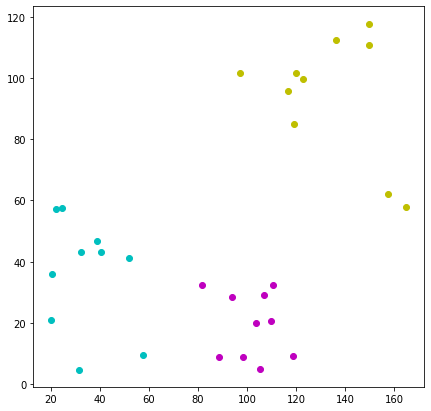

In [2]:
# set seed for reproducibility
np.random.seed(100923)

# generate three random sets of points
r = np.random.rand(2, 10) * 60
g = np.random.rand(2, 10) * 40 + np.array([[80],[0]])
b = np.random.rand(2, 10) * 70 + np.array([[95],[55]])

%matplotlib inline
import matplotlib.pyplot as plt

# plot the three sets
plt.figure(1, figsize=(7,7))
plt.plot(r[0,:], r[1,:], 'co')
plt.plot(g[0,:], g[1,:], 'mo')
plt.plot(b[0,:], b[1,:], 'yo')
plt.show()

# combine the sets
x = np.concatenate((np.concatenate((r, g), axis=1), b), axis=1)

## Clustering the data

The optimal number of centroids to run k-means with is difficult to determine. Therefore the choosen approach is to cluster the data multiple times using different amounts of centroids. For each clustering the cost of the resulting assignment is calculated and compared afterwards. 

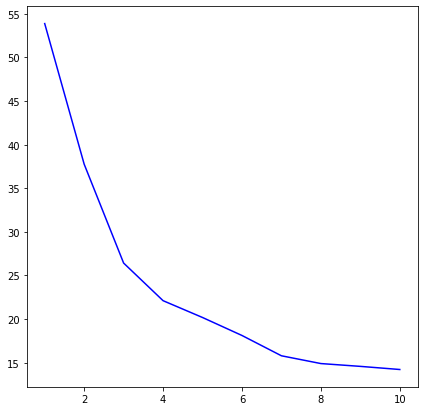

In [3]:
costs = []
max_clusters = 10 # try with 1-10 centroids

for k in range(1, max_clusters+1):
    
    cost = 0
    iterations = 50
    for i in range(iterations):
    
        c_list, centroids_list = k_means(x, k)
        cost += calc_cost(centroids_list[-1], x, c_list[-1])
    
    print("Current cluster: {}".format(k), end="\r")        
    costs.append(cost / iterations)
    
plt.figure(2, figsize=(7,7))
plt.plot(range(1, max_clusters+1), costs, "b-")
plt.show()

Based on the above plot, the optimal amount of centroids is either $3$ or $4$. It is important to note that the $cost$ will go to $0$ if $k$ goes to $m$. Therefore the amount of centroids is choosen at the part of the graph, starting from the beginning of it, where the slope decreases significantly. This is the case between $3$ and $4$.

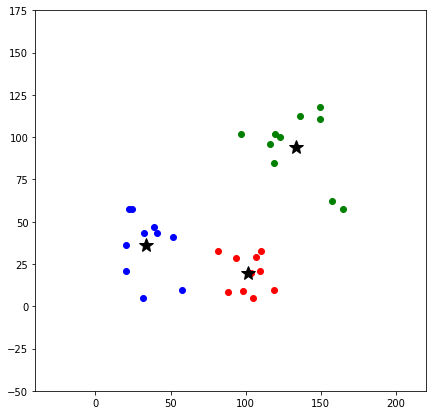

In [4]:
# cluster the given data with 3 centroids
cluster_num = 3
c_list, centroids_list = k_means(x, 3)

import time
from IPython import display

# Plot clustering process
style = ['bo','go', 'ro', 'co', 'mo', 'yo']
plt.figure(1, figsize=(7,7))
for t in range(len(c_list)):
    
    # calc sets to color the data points
    sets = split(c_list[t], x)
    
    # time delay for the 'animation'
    time.sleep(0.5)
    
    # clear the plot
    plt.clf()
    plt.axis([-40, 220, -50, 175])
    
    # plot the data
    for i, set_ in enumerate(sets):
            plt.plot(set_[0,:], set_[1,:], style[i]) # do not use this with more than 6 centroids
            
    plt.plot(centroids_list[t][0,:], centroids_list[t][1,:], 'k*', ms=15)
    
    # handle animation
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Testing

The following code sections can be ignored.

In [5]:
%%script false 

UsageError: %%script is a cell magic, but the cell body is empty.


In [ ]:
# split data tests

a = np.array([3,1,1,1,1,2,2,2,3,3])
data = np.array([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]])

np_a = np.array(a)
np_a_unique = np.unique(np_a)


sets = split(a, data)

for set_ in sets:
    print(set_)

In [ ]:
# cost testing
a = np.array([0, 0])
centroids = np.array([[1],[1]])
b = np.array([[0, 1],[0, 1]])

cost = calc_cost(centroids, b, a)

print(cost)

In [ ]:
a = np.array([[1,2,3],[1,2,3]])
print(a.sum())